# Calculate air-sea fluxes
This builds on `cm26_combine_filter_inputs.ipynb`


In [1]:
!mamba install aerobulk-python -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.1.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['aerobulk-python']

[+] 0.0s
conda-forge/linux-64 ━━━━━━━━━━━╸━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?

In [2]:
!pip install -e /home/jovyan/scale-aware-air-sea/scale-aware-air-sea

Obtaining file:///home/jovyan/scale-aware-air-sea/scale-aware-air-sea
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for scale-aware-air-sea (pyproject.toml) ... done
  Created wheel for scale-aware-air-sea: filename=scale_aware_air_sea-0.0.1-0.editable-py3-none-any.whl size=3272 sha256=6b27f28fe94a742435a938274e7ea91723779ff7001578d7922576d51144b5e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-ea8e3kq3/wheels/ac/9a/71/cc5723b3d1738a7fb2359283c7c9f3f6cb9488e0d5be04738e
Successfully built scale-aware-air-sea


import subprocess
import logging
from distributed import WorkerPlugin

class MambaPlugin(WorkerPlugin):
    """
    Install packages on a worker as it starts up.

    Parameters
    ----------
    packages : List[str]
        A list of packages to install with pip on startup.
    """
    def __init__(self, packages):
        self.packages = packages

    def setup(self, worker):
        logger = logging.getLogger("distributed.worker")
        subprocess.call(['mamba', 'install'] + self.packages)
        logger.info("Installed %s", self.packages)

from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()
options.worker_memory = 28
options.worker_cores = 4

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()

plugin = MambaPlugin(['aerobulk-python'])
client.register_worker_plugin(plugin)
cluster.scale(40)
client

In [1]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=4) # product of these 2 numbers should be =< # of cores
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/paigem/proxy/8787/status,
Dashboard: /user/paigem/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 125.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35339,Workers: 4
Dashboard: /user/paigem/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 125.81 GiB
Comm: tcp://127.0.0.1:41261,Total threads: 4
Dashboard: /user/paigem/proxy/41187/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:35513,


In [2]:
import json
import gcsfs
import xarray as xr


import matplotlib.pyplot as plt
import numpy as np
import os
import dask

from aerobulk import noskin
from scale_aware_air_sea.utils import open_zarr, to_zarr_split, weighted_coarsen
from scale_aware_air_sea.cesm_utils import load_and_combine_cesm
from scale_aware_air_sea.parameters import get_params

In [3]:
def compute_fluxes(
    ds,
    algo,
    method,
    sst_name = 'SST',
    t_name = 'TREFHT',
    q_name = 'QREFHT',
    u_name = 'u_relative',
    v_name = 'v_relative',
    slp_name = 'PSL',
    skin_correction = False
):
    # input dependent on method
    if method == 'smooth_all':
        sst = ds[sst_name+'_filtered']
        t = ds[t_name+'_filtered']
        q = ds[q_name+'_filtered']
        u = ds[u_name+'_filtered']
        v = ds[v_name+'_filtered']
        slp = ds[slp_name+'_filtered']
    elif method == 'smooth_none':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name]
        v = ds[v_name]
        slp = ds[slp_name]
    else:
        raise ValueError(f'`method`{method} not recognized')
        
    # if skin_correction:
    #     func = noskin
    
    ## test ranges on first timestep
    noskin(
        sst.isel(time=0),
        t.isel(time=0),
        q.isel(time=0),
        u.isel(time=0),
        v.isel(time=0),
        slp=slp.isel(time=0),
        algo=algo,
        zt=2,
        zu=55,
        input_range_check=True
    )
    
    
    ds_out = xr.Dataset()
    (
        ds_out['ql'],
        ds_out['qh'],
        ds_out['taux'],
        ds_out['tauy'],
        ds_out['evap']
    ) =  noskin(
        sst,
        t,
        q,
        u,
        v,
        slp=slp,
        algo=algo,
        zt=2,
        zu=55,
        input_range_check=False
    )
    return ds_out

In [4]:
fs = gcsfs.GCSFileSystem()

# load global parameters
params = get_params('v0.7.0', test=False) 

temp_mapper = fs.get_mapper(params['paths']['CESM']['scratch'])
mapper_filter = fs.get_mapper(params['paths']['CESM']['filter'])
#mapper_coarse = fs.get_mapper(params['paths']['CESM']['coarse'])

mapper_filter_fluxes = fs.get_mapper(params['paths']['CESM']['filter_fluxes'])
#mapper_coarse_fluxes = fs.get_mapper(params['paths']['CESM']['coarse_fluxes'])

In [14]:
# fs.rm(mapper_filter_fluxes.root, recursive=True)

In [5]:
algo_options = [
    ('ncar', False), 
    ('ecmwf', False)
]

In [6]:
ds_filter = open_zarr(mapper_filter)
ds_filter

<xarray.Dataset>
Dimensions:              (nlat_t: 2400, nlon_t: 3600, time: 730)
Coordinates: (12/42)
    ANGLET               (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                   (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK          (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                   ...
    sea_ice_salinity     float64 ...
    sflux_factor         float64 ...
    sound                float64 ...
    stefan_boltzmann     float64 ...
  * time                 (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:...
    vonkar               float64 ...
Data variables:
    PSL_filtered         (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    QREFHT_filtered      (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_filtered         (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TREFHT_filtered      (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative_filtered  (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative_filtered  (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

ds_coarse = open_zarr(mapper_coarse)
ds_coarse

In [7]:
if not fs.exists(temp_mapper.root):
    print('Recreating temp store from scratch')
    ds_merged_raw  = load_and_combine_cesm(fs, inline_array=True)

    # Only process a small dataset if the version is a test
    if 'test' in params['version']:
        ds_merged_raw = ds_merged_raw.isel(time=slice(0,30))
    
    to_zarr_split(ds_merged_raw, temp_mapper, split_interval=150)# old 150try 200 next, this is very underpowered.
    
# overwrite with reloaded store
ds_original = open_zarr(temp_mapper)
# ds_original = xr.open_dataset(temp_mapper, engine='zarr', chunks={})
ds_original

<xarray.Dataset>
Dimensions:             (nlat_t: 2400, nlon_t: 3600, time: 730)
Coordinates: (12/42)
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:0...
    vonkar              float64 ...
Data variables:
    PSL                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    QREFHT              (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TREFHT              (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TS                  (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U10                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    UBOT                (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    VBOT                (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_ocean             (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative          (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_ocean             (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative          (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [8]:
ds_filter = xr.merge([ds_filter, ds_original], join='inner')
ds_filter

<xarray.Dataset>
Dimensions:              (nlat_t: 2400, nlon_t: 3600, time: 730)
Coordinates: (12/42)
    ANGLET               (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                   (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK          (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                   ...
    sea_ice_salinity     float64 0.0
    sflux_factor         float64 0.0
    sound                float64 0.0
    stefan_boltzmann     float64 0.0
  * time                 (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:...
    vonkar               float64 0.0
Data variables: (12/18)
    PSL_filtered         (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    QREFHT_filtered      (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_filtered         (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TREFHT_filtered      (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative_filtered  (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative_filtered  (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    ...                   ...
    UBOT                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    VBOT                 (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_ocean              (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    u_relative           (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_ocean              (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    v_relative           (time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Apply computation on smoothed_data

In [9]:
datasets = []
for (algo, skin_correction) in algo_options:
    algo_datasets = []
    for method in [
        'smooth_none',
        'smooth_all'
    ]:
        ds_method = compute_fluxes(ds_filter, algo, method, skin_correction=skin_correction)
        ds_method = ds_method.assign_coords(smoothing=method)
        algo_datasets.append(ds_method)
    ds_algo = xr.concat(algo_datasets, dim='smoothing')
    ds_algo = ds_algo.assign_coords({'algo':f"{algo}{'_'+skin if skin_correction else ''}"})
    datasets.append(ds_algo)
ds_filter_fluxes = xr.concat(datasets, dim='algo')
ds_filter_fluxes

/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
 

<xarray.Dataset>
Dimensions:             (nlat_t: 2400, nlon_t: 3600, time: 730, algo: 2,
                         smoothing: 2)
Coordinates: (12/44)
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
  * time                (time) object 0078-01-01 00:00:00 ... 0079-12-31 00:0...
    vonkar              float64 0.0
  * smoothing           (smoothing) <U11 'smooth_none' 'smooth_all'
  * algo                (algo) <U5 'ncar' 'ecmwf'
Data variables:
    ql                  (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
    qh                  (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
    taux                (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
    tauy                (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
    evap                (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>

In [11]:
roi = dict(nlon_t=slice(200,500), nlat_t=slice(1300,1600))

In [12]:
test = ds_filter_fluxes.ql.isel(time=-1, algo=0).sel(smoothing='smooth_none').sel(**roi).load()

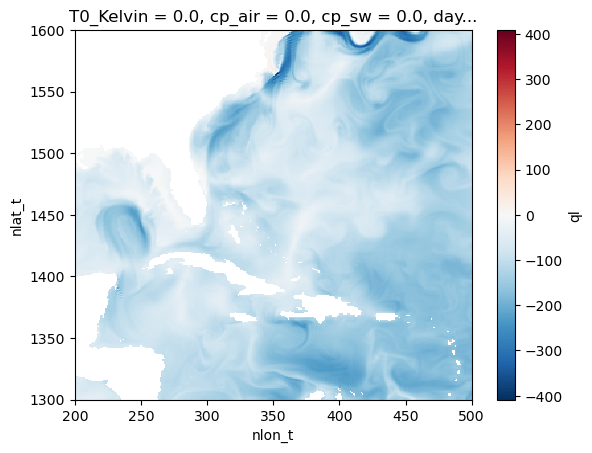

In [13]:
test.plot()

In [15]:
test = ds_filter_fluxes.taux.isel(time=-1, algo=0).sel(smoothing='smooth_none').sel(**roi).load()

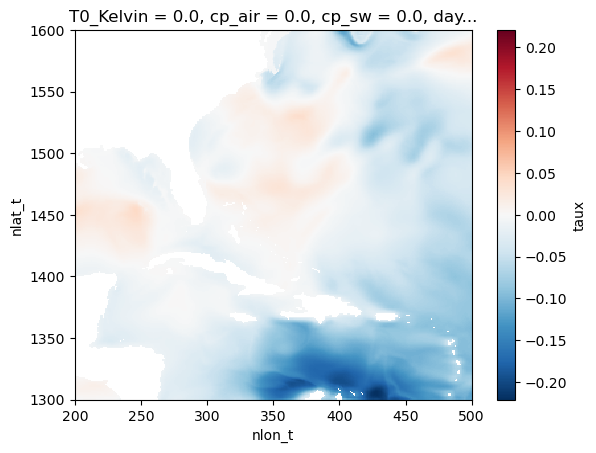

In [16]:
test.plot()

## Save out data

### Save smoothed data

In [10]:
#ds_save = ds_filter_fluxes
to_zarr_split(ds_filter_fluxes, mapper_filter_fluxes, split_interval=150)

Writing to leap-persistent/jbusecke/scale-aware-air-sea/results/CESM_fluxes_filter_v0.7.0.zarr ...


  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
# reload the smoothed flux data
ds_reload_filter_fluxes = open_zarr(mapper_filter_fluxes)
ds_reload_filter_fluxes

<xarray.Dataset>
Dimensions:             (nlat_t: 2400, nlon_t: 3600, algo: 2, smoothing: 2,
                         time: 30)
Coordinates: (12/44)
    ANGLET              (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat_t, nlon_t) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sflux_factor        float64 ...
  * smoothing           (smoothing) <U11 'smooth_none' 'smooth_all'
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0078-01-01 00:00:00 ... 0078-01-30 00:0...
    vonkar              float64 ...
Data variables:
    evap                (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
    qh                  (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
    ql                  (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
    taux                (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>
    tauy                (algo, smoothing, time, nlat_t, nlon_t) float32 dask.array<chunksize=(1, 1, 1, 2400, 3600), meta=np.ndarray>

# Plots

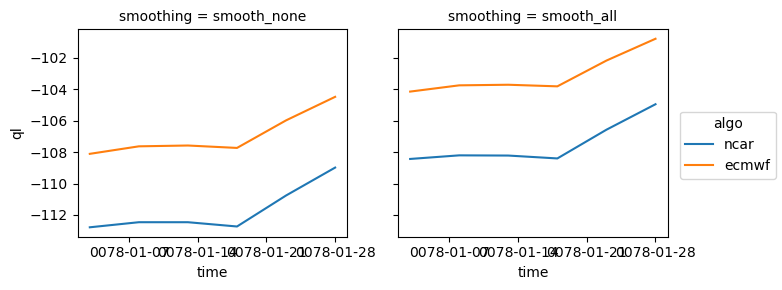

In [19]:
da_plot_filter = ds_reload_filter_fluxes.ql.weighted(ds_reload_filter_fluxes.TAREA).mean(['nlon_t', 'nlat_t']).load()
da_plot_filter.coarsen(time=5, boundary='trim').mean().plot(hue='algo', col='smoothing')

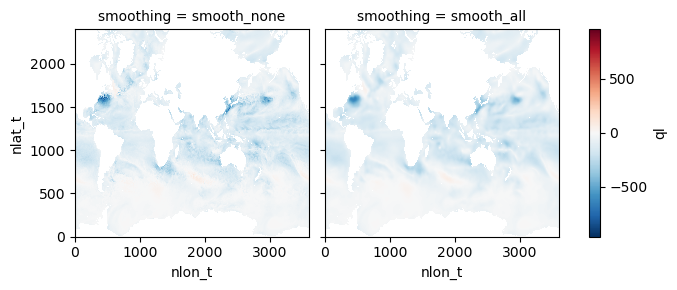

In [18]:
ds_reload_filter_fluxes['ql'].isel(algo=0, time=0).plot(col='smoothing')

## Apply computation on coarsened data (this relies on reloaded smoothed data, specifically the smooth_none method)

In [12]:
datasets = []
# for this dataset we only have two methods
# 1. The equivalent to 'smooth_all' where we compute fluxes on the coarsened output
# This needs to be computed over every algo
for (algo, skin_correction) in algo_options:
    # The equivalent to 'smooth_all' where we compute fluxes on the coarsened output
    ds_coarse_single_algo = compute_fluxes(ds_coarse, algo, 'smooth_none', skin_correction=skin_correction)
    # FIXME: this naming is not really easy to understand
    # I could rename the coarsened data before? 
    ds_coarse_single_algo = ds_coarse_single_algo.assign_coords(smoothing='smooth_all')
    datasets.append(ds_coarse_single_algo)
ds_all_coarse = xr.concat(datasets, dim='algo')
# and the equivalent to smooth none, where we coarsen the full res flux output
# this is based on the other precomputed data, so all the algos are there already
ds_none_coarse = weighted_coarsen(
    ds_reload_filter_fluxes.sel(smoothing='smooth_none'), 
    {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']},
    'area_t'
).assign_coords(smoothing='smooth_none')

# Finally concat along the 'smoothing' dimension (FIXME: better naming for this would be nice).
ds_full_coarse = xr.concat([ds_none_coarse, ds_all_coarse], dim='smoothing')
ds_full_coarse

/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
 

<xarray.Dataset>
Dimensions:    (algo: 5, smoothing: 2, time: 7305, yt_ocean: 54, xt_ocean: 72)
Coordinates: (12/13)
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    area_t     (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dyt        (yt_ocean, xt_ocean) float64 4.697e+03 4.697e+03 ... 370.3
    geolat_t   (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 52.3 0.0 0.0 0.0
    ...         ...
    ht         (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    kmt        (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wet        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * xt_ocean   (xt_ocean) float64 -277.5 -272.5 -267.5 -262.5 ... 67.5 72.5 77.5
  * yt_ocean   (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
    dxt        (yt_ocean, xt_ocean) float64 1.917e+03 1.917e+03 ... 4.525e+03
Data variables:
    evap       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    qh         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    ql         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    taux       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    tauy       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>

### Test Plots Coarsened

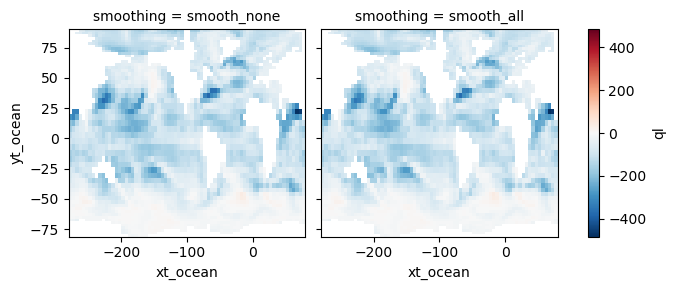

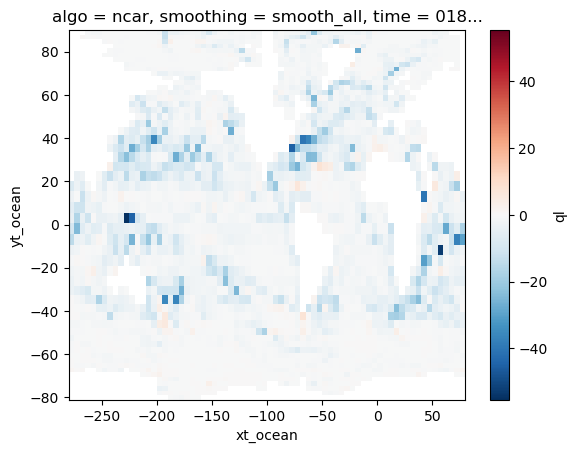

In [13]:
ds_full_coarse.ql.isel(algo=0, time=0).plot(col='smoothing')

plt.figure()
(-ds_full_coarse.ql.isel(algo=0, time=0).diff('smoothing')).plot()

### Save coarsened data

In [16]:


fs.rm(mapper_coarse_fluxes.root, recursive=True)
to_zarr_split(ds_full_coarse, mapper_coarse_fluxes, split_interval=300)

# ds_save.to_zarr(mapper_coarse_fluxes, mode='w')# kills the scheduler

Writing to leap-persistent/jbusecke/scale-aware-air-sea/results/CM26_fluxes_coarse_50_v0.7.0.zarr ...


  0%|          | 0/24 [00:00<?, ?it/s]

In [13]:
# reload the coarsened flux data
ds_reload_coarse = open_zarr(mapper_coarse_fluxes, chunks={'time':3000})
ds_reload_coarse

<xarray.Dataset>
Dimensions:    (algo: 5, yt_ocean: 54, xt_ocean: 72, smoothing: 2, time: 7305)
Coordinates: (12/13)
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    dxt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
    ...         ...
    kmt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    wet        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * xt_ocean   (xt_ocean) float64 -277.5 -272.5 -267.5 -262.5 ... 67.5 72.5 77.5
  * yt_ocean   (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
Data variables:
    evap       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3000, 54, 72), meta=np.ndarray>
    qh         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3000, 54, 72), meta=np.ndarray>
    ql         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3000, 54, 72), meta=np.ndarray>
    taux       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3000, 54, 72), meta=np.ndarray>
    tauy       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3000, 54, 72), meta=np.ndarray>

#### Check missing time values

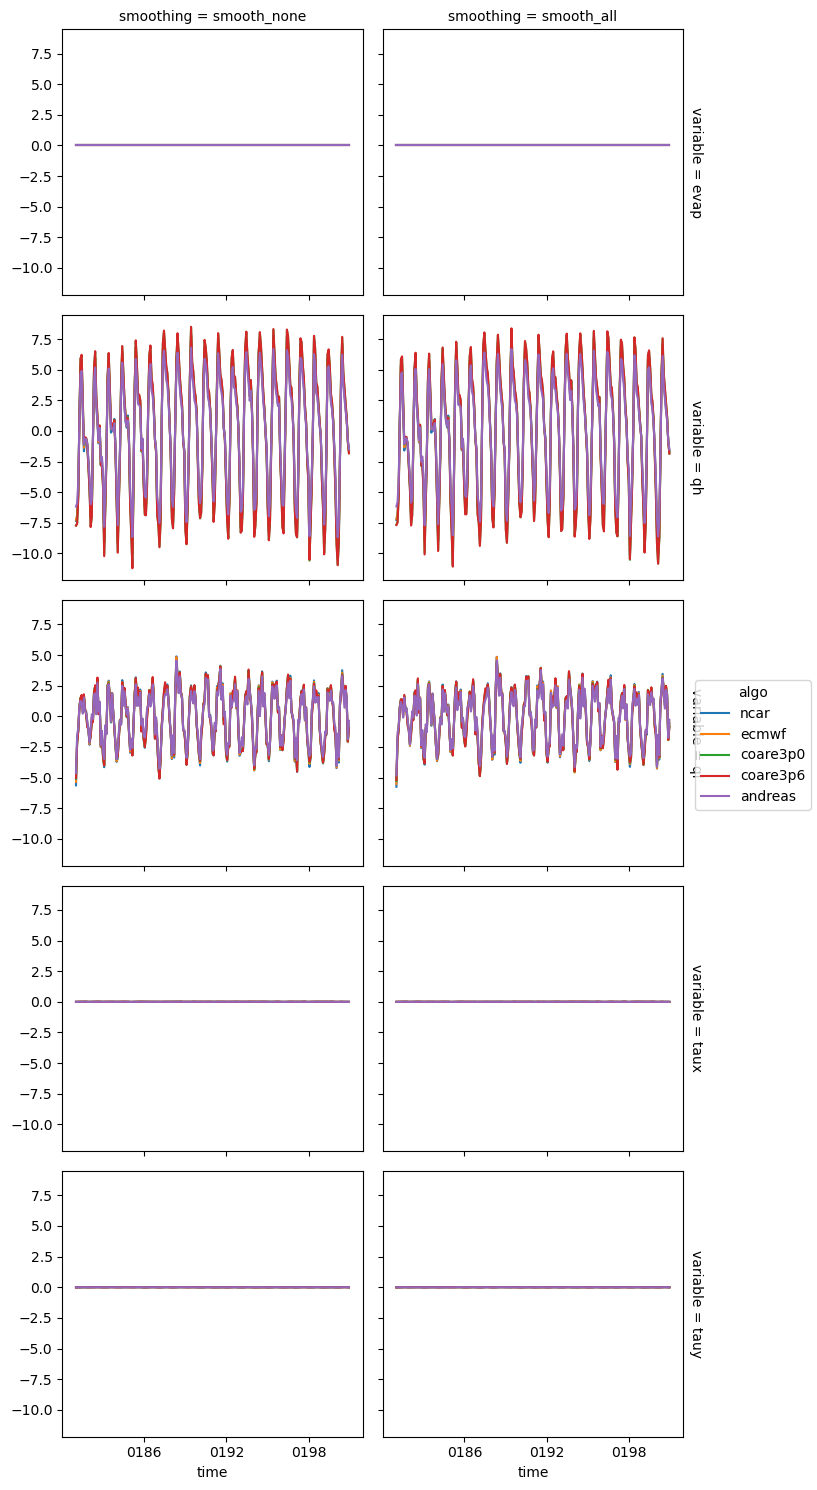

In [15]:
da_plot_coarse = ds_reload_coarse.weighted(ds_reload_coarse.area_t).mean(['xt_ocean', 'yt_ocean']).to_array().load()
(da_plot_coarse-da_plot_coarse.mean('time')).coarsen(time=30, boundary='trim').mean().plot(hue='algo', col='smoothing', row='variable')

#### Rough check on the 'small scale'
This is not really right? I should take the difference before the average...but then again, this should be linear?

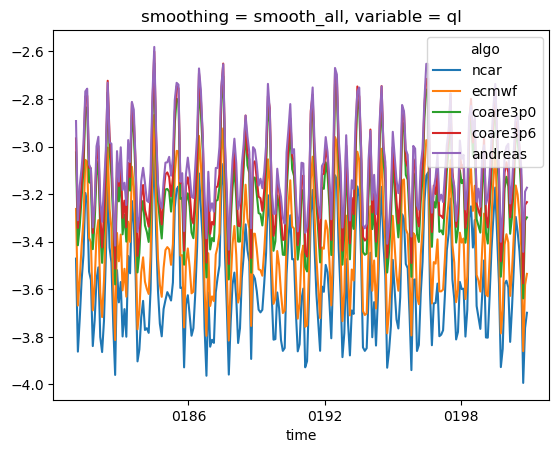

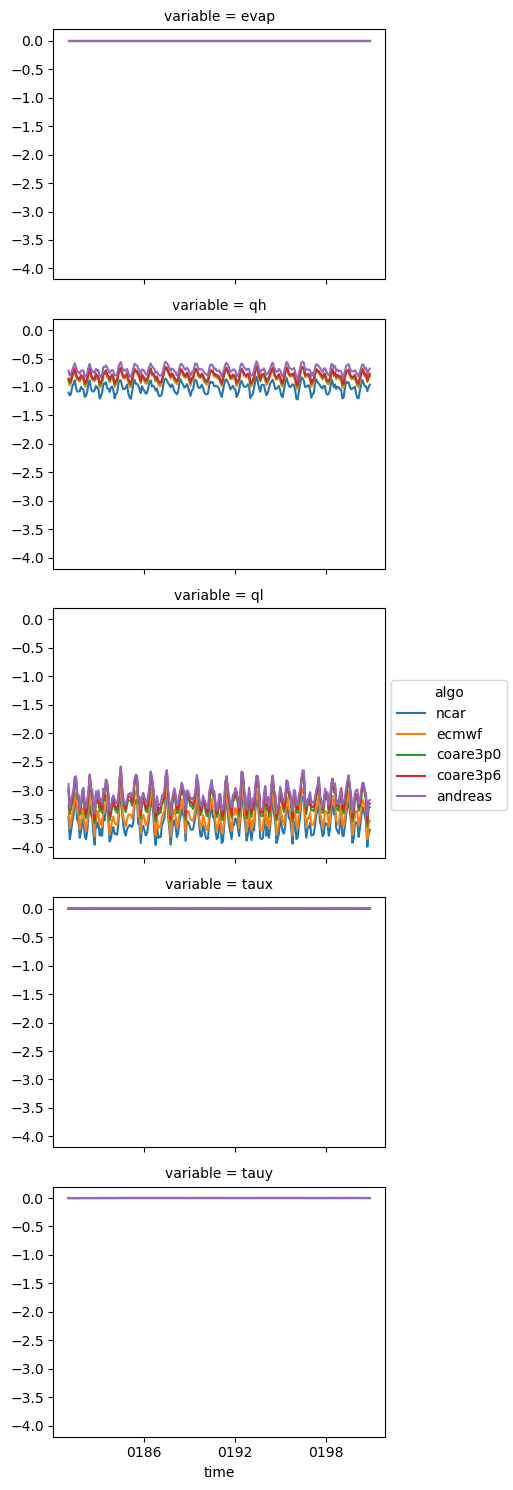

In [19]:
(-da_plot_coarse.sel(variable='ql').diff('smoothing')).coarsen(time=30, boundary='trim').mean().plot(hue='algo')
(-da_plot_coarse.sel(smoothing=['smooth_none', 'smooth_all']).diff('smoothing')).coarsen(time=30, boundary='trim').mean().plot(hue='algo', row='variable')

In [23]:
cluster.shutdown()